In [1]:
from __future__ import annotations
import sys
sys.path.append('/work/yadegari/optim/')

from extract_best_paramset import extract_info
from util import import_control_file


In [2]:
root_path = '/work/yadegari/multibasin_study_1/'

In [3]:
sets = [f'set_{i}' for i in range(1, 11)]
sets

['set_1',
 'set_2',
 'set_3',
 'set_4',
 'set_5',
 'set_6',
 'set_7',
 'set_8',
 'set_9',
 'set_10']

In [4]:
def get_best_kge(group, set_k) -> float:
    return extract_info(f'{root_path}/{group}/{set_k}/control_file_squash.py')[0]

def get_num_iterations(group, set_k) -> int:
    with open(f'{root_path}/{group}/{set_k}/runs/res.txt') as fh:
        lines = fh.readlines()
    return len(lines) // 2

import re

def get_key(set_name:str) -> str:
    '''removes underscore from the set_name: f("set_5") -> "set 5"'''
    return re.sub(r'(.+)_(\d+)', r'\1 \2', set_name)
    
def get_data(func, sets:list[str]) -> dict:
    return {
        get_key(set_k): {
            'with_bucketsystem': func('with_bucket_system', set_k),
            'without_bucketsystem': func('without_bucket_system', set_k)
        } for set_k in sets
    }

In [5]:
data_kge = get_data(get_best_kge, sets)
data_iternums = get_data(get_num_iterations, sets)

In [6]:
import sys
sys.path.append('/work/yadegari/optim_crash/util.py')

from util import import_control_file

def get_scaled_progress(data_iternums):
    cf_with = import_control_file(f'{root_path}/with_bucket_system/set_1/control_file_squash.py')[0]
    cf_without = import_control_file(f'{root_path}/without_bucket_system/set_1/control_file_squash.py')[0]
    
    nparam_with = len(cf_with.params)
    nparam_without = len(cf_without.params)
    iter_per_param = 100
    
    # probab according to DDS
    p = lambda m, n: 1 - np.log(m) / np.log(n)
    
    
    for set_k, data in data_iternums.items():
        for group in data:
            if group == 'with_bucketsystem':
                data[group] = data[group] / (iter_per_param * nparam_with)
            if group == 'without_bucketsystem':
                data[group] = data[group] / (iter_per_param * nparam_without)
    
    return data_iternums

data_iternums = get_scaled_progress(data_iternums)

In [7]:
def set_labels(ax, xlabel, ylabel, kwargs={}):
    ax.set_xlabel(xlabel, **kwargs)
    ax.set_ylabel(ylabel, **kwargs)  
    
def draw_plot(ax, data:dict):
    get_data = lambda data, name: (data.keys(), [data[k][name] for k in data])
    
    ax.plot(*get_data(data, 'with_bucketsystem'), 
        'o', ms=10, label='with bucketsystem')

    ax.plot(*get_data(data, 'without_bucketsystem'),
        '^', ms=10, label='without bucketsystem')

In [8]:
data_iternums

{'set 1': {'with_bucketsystem': 0.16818181818181818,
  'without_bucketsystem': 0.5797959183673469},
 'set 2': {'with_bucketsystem': 0.17597402597402598,
  'without_bucketsystem': 0.5528571428571428},
 'set 3': {'with_bucketsystem': 0.2785714285714286,
  'without_bucketsystem': 0.4110204081632653},
 'set 4': {'with_bucketsystem': 0.29454545454545455,
  'without_bucketsystem': 0.666734693877551},
 'set 5': {'with_bucketsystem': 0.08597402597402598,
  'without_bucketsystem': 0.5963265306122449},
 'set 6': {'with_bucketsystem': 0.13545454545454547,
  'without_bucketsystem': 0.31918367346938775},
 'set 7': {'with_bucketsystem': 0.24675324675324675,
  'without_bucketsystem': 0.8344897959183674},
 'set 8': {'with_bucketsystem': 0.48,
  'without_bucketsystem': 0.606938775510204},
 'set 9': {'with_bucketsystem': 0.11948051948051948,
  'without_bucketsystem': 0.33122448979591834},
 'set 10': {'with_bucketsystem': 0.33194805194805194,
  'without_bucketsystem': 0.5248979591836734}}

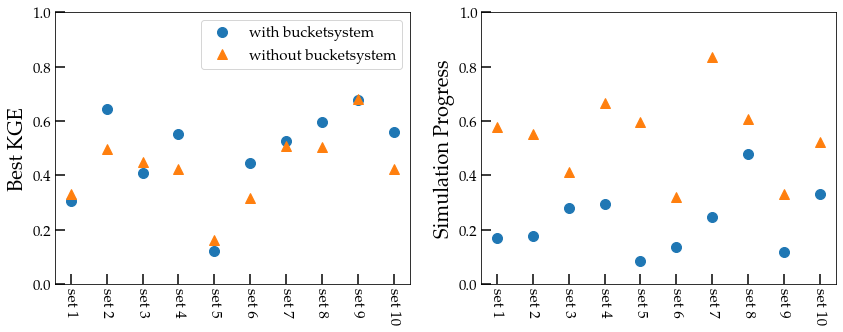

In [9]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "P052"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

draw_plot(ax1, data_kge)
draw_plot(ax2, data_iternums)

for ax in (ax1, ax2):
    ax.tick_params(direction='in',
                   length=10,
                   width=1.5,
                   labelsize=15)
    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)

set_labels(ax1, '', 'Best KGE', {'size':20})    
set_labels(ax2, '', 'Simulation Progress', {'size':20})  
    
ax1.legend(loc='upper right',
           prop={'size':15})

kwargs = {
#     'title': '2D histogram of Multivariate Gaussian',
    'ylim': [0, 1],
#     'xlim': [-4, 4]
}
ax1.set(**kwargs);


kwargs = {
    'ylim': [0, 1],
}
    
ax2.set(**kwargs)

plt.savefig('kge-iteration.pdf')

In [10]:
def get_control_file(group):
    '''always returns the one in set_1'''
    assert group == 'with_bucket_system' or group == 'without_bucket_system'
    path = f'{root_path}/{group}/set_1/control_file_squash.py'
    return import_control_file(path)[0]

In [11]:
def get_best_paramset(group, set_k) -> dict[str, float]:
    return extract_info(f'{root_path}/{group}/{set_k}/control_file_squash.py')[2]

In [12]:
from dataclasses import dataclass
from dataclasses import field

@dataclass
class Param:
    name: str
    param_max: float
    param_min: float
    param_vals: list[float] = field(default_factory=list)
    param_vals_scaled: list[float] = field(default_factory=list)
        
    def __post_init__(self):
        assert self.param_max > self.param_min
        
    def add(self, v):
        if not self.param_min <= v <= self.param_max:
            print(f'for {self.name} the bounds are violated: {v}, {self.param_min}, {self.param_max}')
        self.param_vals.append(v)

In [13]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def scale_params(xs, v_min, v_max):
    return MinMaxScaler().fit(
        np.array([[v_min, v_max]]).T).transform(
        np.array([xs]).T).squeeze()


In [14]:
def prepare_parameters(group, sets):
    '''create a dictionary of scaled parameters for plotting'''
    cf = get_control_file(group)
    d = {}
    
    for param_name in cf.params.keys():
        v_min, v_max, _ = cf.params[param_name]
        d[param_name] = Param(name=param_name, param_min=v_min, param_max=v_max)

    for set_name in sets:
        best_paramset = get_best_paramset(group, set_name)
        for param_name, param_val in best_paramset.items():
            d[param_name].add(param_val)
        
    for _, param in d.items():
        param.param_vals_scaled = scale_params(np.array(param.param_vals),
                                               v_min=param.param_min,
                                               v_max=param.param_max)
        
    return d
    

In [15]:
shared_distributed_params = ['a5', 'a6', 'b5', 'b6', 'c5', 'c6', 'hveg_rsm_scaling', 'lveg_rsm_scaling', 'mlaih_scaling', 'mlail_scaling', 'thetar_1', 'thetar_4', 'zach_thetas_1', 'zach_thetas_2', 'zach_thetas_3', 'zach_thetas_4', 'zach_thetas_5', 'zach_thetas_6', 'zach_vga_1', 'zach_vga_2', 'zach_vga_3', 'zach_vga_4', 'zach_vga_5', 'zach_vga_6', 'zach_vga_7', 'zach_vga_8', 'zach_vgn_1', 'zach_vgn_10', 'zach_vgn_2', 'zach_vgn_3', 'zach_vgn_4', 'zach_vgn_5', 'zach_vgn_6', 'zach_vgn_7', 'zach_vgn_8', 'zach_vgn_9']

In [16]:
import re


def add_leading_zero(s):
    '''adds a leading zero to 1-digit numbers'''
    text, num = re.match(r'(.+?)(\d*)$', s).groups()
    if not num:
        return s
    assert 0 < int(num) < 100, num
    s_leading_zero = f'{int(num):02}'
    return text + s_leading_zero


def remove_leading_zero(s):
    text, num = re.match(r'(.+?)(\d*)$', s).groups()
    if not num:
        return s
    return text + str(int(num))


def add_leading_zero_to_keys(d:dict):
    return {
        add_leading_zero(k): v for k, v in d.items()
    }


def remove_leading_zero_from_keys(d:dict):
    return {
        remove_leading_zero(k): v for k, v in d.items()
    }


def sort_dict(d:dict):
    return remove_leading_zero_from_keys(
        dict(
            sorted(
                add_leading_zero_to_keys(d).items()
            )
        )
    )


def take_from_keys(d:dict, keys):
    return {
        k: d[k] for k in keys
    }

In [17]:
params_without = sort_dict(
    take_from_keys(
        prepare_parameters('without_bucket_system', sets),
        shared_distributed_params)
)
params_with = sort_dict(
    take_from_keys(
        prepare_parameters('with_bucket_system', sets),
        shared_distributed_params))

for rtf1 the bounds are violated: 272.0, 272.1, 276.0
for ralamsn the bounds are violated: 2.07, 1.692, 2.068
for a5 the bounds are violated: 1.42, 0.5025, 1.4175
for ralamsn the bounds are violated: 2.07, 1.692, 2.068
for ralamsn the bounds are violated: 2.07, 1.692, 2.068
for rtf1 the bounds are violated: 272.0, 272.1, 276.0
for ralamsn the bounds are violated: 2.07, 1.692, 2.068


In [18]:
def make_x_points(ys:list[np.array], offset, std):
    xs = []
    for idx, y in enumerate(ys):
        xs.append(np.random.normal(idx+offset, std, size=len(y)))
    return xs


def plot_points(ax, xs, ys, color, ms):
    for x, y in zip(xs, ys):
        ax.plot(x, y, 'x', color=color, ms=ms)
        
def plot_box(ax, ys, offset, width, color):
    
    kwargs =  {'patch_artist': True,
               'boxprops': dict(color=color, facecolor='none'),
               'capprops': dict(color=color),
               'flierprops': dict(color=color, markeredgecolor=color),
#                'medianprops': dict(color=c),
               'whiskerprops': dict(color=color)}

    return ax.boxplot(
        ys, 
        positions=np.arange(len(ys)) + offset,
        widths=width,
    
        **kwargs
    );


def plot(ax, params_dict, offset, width, color, plot_dots=True):
    keys = params_dict.keys()
    ys = [p.param_vals_scaled for p in params_dict.values()]
    if plot_dots:
        xs = make_x_points(ys, offset, std=0)
        plot_points(ax, xs, ys, 'red', 2)
    
    ph = plot_box(ax, ys, offset, width, color)
    ax.set_xticks(range(len(keys)));
    ax.set_xticklabels(keys);
    return ph

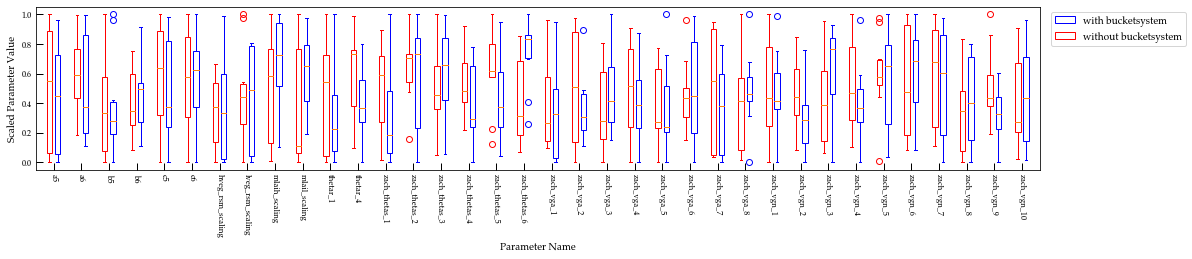

In [19]:
fig, ax = plt.subplots(figsize=(18, 3))

offset = 0.15

h_with = plot(ax, params_with, offset, 0.2, 'blue', plot_dots=False)
h_without = plot(ax, params_without, -offset, 0.2, 'red', plot_dots=False)

ax.legend([h_with['boxes'][0], h_without['boxes'][0]],
          ['with bucketsystem', 'without bucketsystem'],
          loc='upper right',
          bbox_to_anchor=(1.15, 1))

for ax in [ax]:
    ax.tick_params(direction='in',
                   length=7,
                   width=1.0,
                   labelsize=8)
    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)
        
ax.set_ylabel('Scaled Parameter Value')
ax.set_xlabel('Parameter Name')

plt.savefig('scaled_params.pdf', bbox_inches='tight')        